In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

from nltk.corpus import stopwords

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

# Dataframe

In [38]:
%%time

def to_list(entry):
  return list(json.loads(entry).values())

meta = pd.read_csv("./data/movie.metadata.tsv", sep = '\t', header = None)
meta.columns = [
    'id_wiki', 'id_freebase',
    "title", 'release date',
    'box office revenue', 'runtime',
    'languages', 'countries', 'genres']

meta['languages'] = meta['languages'].apply(to_list)
meta['countries'] = meta['countries'].apply(to_list)
meta['genres'] = meta['genres'].apply(to_list)

#meta['languages'] = meta['languages'].apply(lambda x: np.nan if len(x)==0 else x)
#meta['countries'] = meta['countries'].apply(lambda x: np.nan if len(x)==0 else x)
#meta['genres'] = meta['genres'].apply(lambda x: np.nan if len(x)==0 else x)
meta.head()

CPU times: user 1.28 s, sys: 92.5 ms, total: 1.37 s
Wall time: 1.38 s


,id_wiki,id_freebase,title,release date,box office revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thriller]"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [39]:

plots = []
with open("./data/plot_summaries.txt", 'r') as f:
  reader = csv.reader(f, dialect='excel-tab')
  for row in tqdm(reader): # tqdm, A Fast, Extensible Progress Bar for Python and CLI
      plots.append(row)

id_wiki = []
plot = []

for i in tqdm(plots):
  id_wiki.append(i[0])
  plot.append(i[1])

plots = pd.DataFrame({'id_wiki': id_wiki, 'plot': plot})
plots.head()

42303it [00:01, 23718.74it/s]
100%|██████████| 42303/42303 [00:00<00:00, 1183421.99it/s]


,id_wiki,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [40]:
meta['id_wiki'] = meta['id_wiki'].astype(str)
cols = ['id_wiki','title','plot','genres']

df = pd.merge(plots, meta[['id_wiki', 'title', 'genres']], on = 'id_wiki')
df = df[cols]
df.head()

,id_wiki,title,plot,genres
0,23890098,Taxi Blues,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.","[Drama, World cinema]"
1,31186339,The Hunger Games,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,Narasimham,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...","[Musical, Action, Drama, Bollywood]"
3,2231378,The Lemon Drop Kid,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...","[Screwball comedy, Comedy]"
4,595909,A Cry in the Dark,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [34]:
all_genres = sum(df['genres'],[])
all_genres = nltk.FreqDist(all_genres) 

df_genres = pd.DataFrame({
    'Genre': list(all_genres.keys()),
    'Count': list(all_genres.values())})

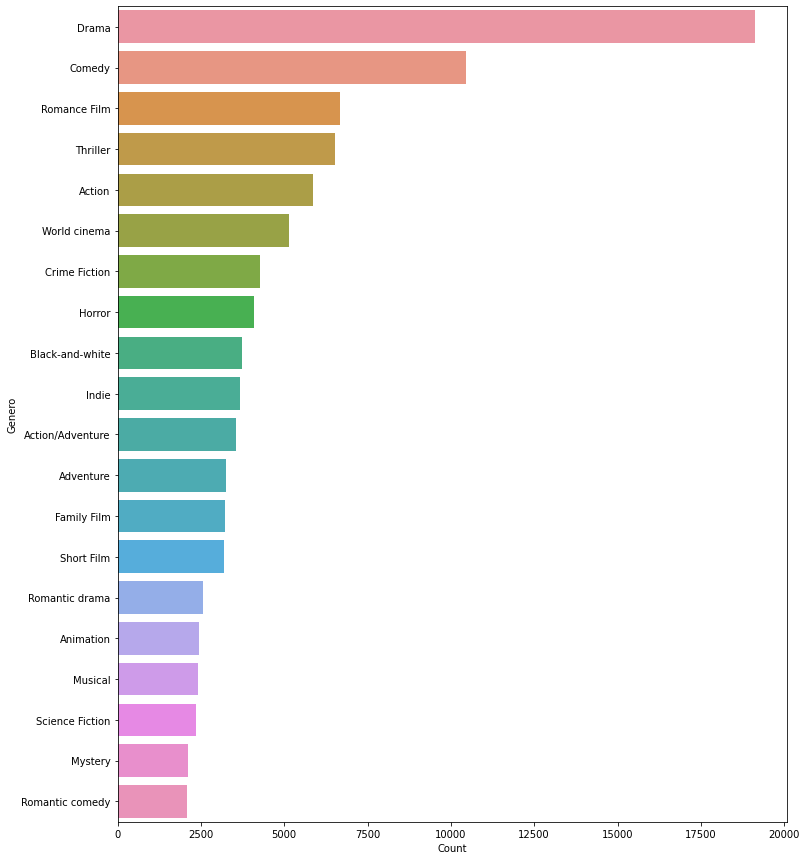

In [36]:
plt.figure(figsize=(12,15))

g = df_genres.nlargest(columns="Count", n = 20) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(xlabel = 'Count', ylabel = 'Genero') 
plt.show()

# Pré-Processamento

In [45]:
stop_words = set(stopwords.words('english'))

def clean(text):
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]"," ",text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['plot_pre'] = df['plot'].apply(clean)
df['plot_pre'] = df['plot_pre'].apply(remove_stopwords)
cols = ['id_wiki','title','plot','plot_pre','genres']
df = df[cols]
df.head()

,id_wiki,title,plot,plot_pre,genres
0,23890098,Taxi Blues,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",shlykov hard working taxi driver lyosha saxophonist develop bizarre love hate relationship despite prejudices realize arent different,"[Drama, World cinema]"
1,31186339,The Hunger Games,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",nation panem consists wealthy capitol twelve poorer districts punishment past rebellion district must provide boy girl ages selected lottery annual hunger games tributes must fight death arena sole survivor rewarded fame wealth first reaping year old primrose everdeen chosen district older siste...,"[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,Narasimham,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",poovalli induchoodan sentenced six years prison life murdering classmate induchoodan son justice maranchery karunakara menon framed case manapally madhavan nambiar crony dysp sankaranarayanan take revenge idealist judge menon earlier given jail sentence manapally corruption case induchoodan achi...,"[Musical, Action, Drama, Bollywood]"
3,2231378,The Lemon Drop Kid,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",lemon drop kid new york city swindler illegally touting horses florida racetrack several successful hustles kid comes across beautiful gullible woman intending bet lot money kid convinces switch bet employing prefabricated con unfortunately kid woman belongs notorious gangster moose moran money ...,"[Screwball comedy, Comedy]"
4,595909,A Cry in the Dark,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",seventh day adventist church pastor michael chamberlain wife lindy two sons nine week old daughter azaria camping holiday outback baby sleeping tent family enjoying barbecue fellow campers cry heard lindy returns tent check azaria certain sees dingo something mouth running approaches discovers i...,"[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


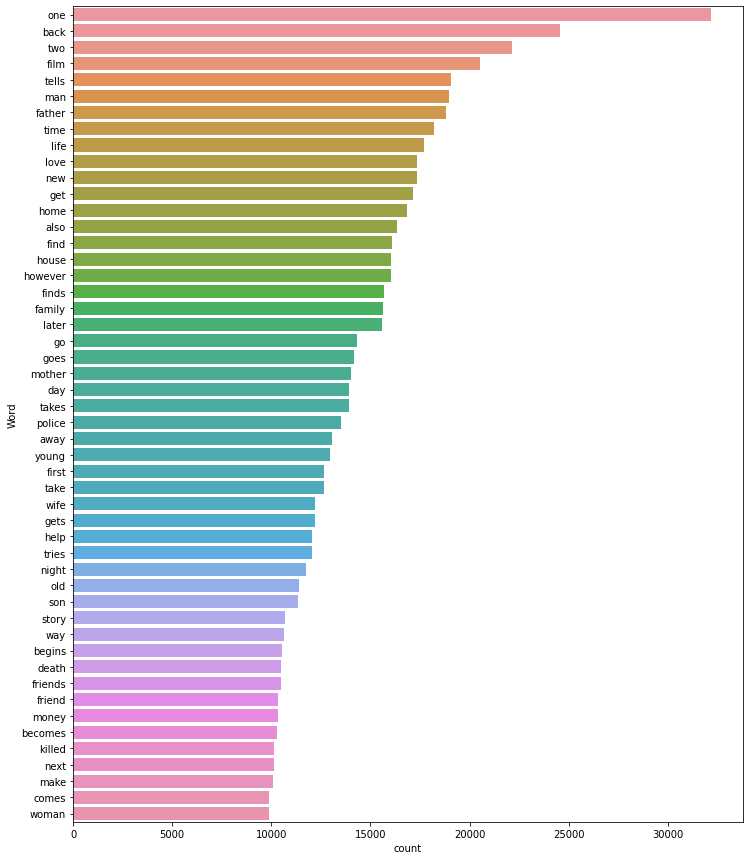

In [47]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    d = words_df.nlargest(columns="count", n = terms) 

    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

freq_words(df['plot_pre'], 50)

In [48]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])
y = multilabel_binarizer.transform(df['genres'])

In [49]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain, xval, ytrain, yval = train_test_split(df['plot_pre'], y, test_size=0.2, random_state=9)

xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [50]:
%%time

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

clf.fit(xtrain_tfidf, ytrain)
y_pred = clf.predict(xval_tfidf)

multilabel_binarizer.inverse_transform(y_pred)[3]

/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 281 is present in all training examples.
  warnings.warn(
/home/cecilio/Projetos/ufsj-Data-Science/.venv/lib/python3.9/site-packages/sklearn/multicla

CPU times: user 11min 52s, sys: 8min 46s, total: 20min 38s
Wall time: 6min 38s


('Drama',)

In [51]:
f1_score(yval, y_pred, average="micro")

0.3115775496654921

In [52]:
y_pred_prob = clf.predict_proba(xval_tfidf)

In [53]:
t = 0.3
y_pred_new = (y_pred_prob >= t).astype(int)

In [54]:
f1_score(yval, y_pred_new, average="micro")

0.43893610964252305

In [55]:
def infer_tags(q):
    q = clean(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [58]:
for i in range(20): 
  k = xval.sample(1).index[0]
  print(
      "Movie: ", df['title'][k],
      "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ", df['genres'][k], "\n")

Movie:  The Best Little Whorehouse in Texas 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Romantic comedy', 'LGBT', 'Sex comedy', 'Musical comedy', 'Musical', 'Comedy', 'Romance Film'] 

Movie:  As Seen Through a Telescope 
Predicted genre:  [()]
Actual genre:  ['Short Film', 'Silent film', 'Indie', 'Black-and-white'] 

Movie:  Captain Jack 
Predicted genre:  [('Drama',)]
Actual genre:  ['Action/Adventure', 'Comedy', 'Adventure'] 

Movie:  Back to the Future Part III 
Predicted genre:  [()]
Actual genre:  ['Science Fiction', 'Adventure', 'Western', 'Comedy', 'Family Film', 'Hybrid Western'] 

Movie:  The Sun of the Sleepless 
Predicted genre:  [('Drama',)]
Actual genre:  ['Crime Fiction', 'Drama'] 

Movie:  The Man from Colorado 
Predicted genre:  [('Drama',)]
Actual genre:  ['Action/Adventure', 'Western', 'Drama'] 

Movie:  A Dennis the Menace Christmas 
Predicted genre:  [()]
Actual genre:  ['Family Film', 'Comedy'] 

Movie:  The File on Thelma Jordon 
Predicted genre:  [('Drama'